<table>
  <tr>
    <td><p style="font-size:45px; color: #55BBD2">Analysis of light microscopy images in Python</p></td>
    <td><img src="../ressources/lmb_logo.svg" alt="LMB Logo" width="500" height="600" align="right"></td>
  </tr>
</table>
<table>
  <tr>
    <td><p style="font-size:15px; color: #55BBD2">Version: September 2025</p></td>
  </tr>
</table>

# Part 3: Particle tracking

In this part 3 of the course, we hope the course attendees will be able to:
- do spot detection,
- track particle using the laptrack package,
- display tracks on napari,
- save tracks in an excelsheet.

### Image analysis problem:

There are different methods we can use to track particles. Here we will use a spot detection, called blob detection. This technique aims at detecting regions in a digital image that differ in properties, such as brightness or color, compared to surrounding regions. The Difference of Gaussian (DoG) method is one technique to detect blobs. For each blob found (a spot in our case), the method returns its coordinates position and the standard deviation of the Gaussian kernel that detected the spot. 

The workflow of our image analysis is illustrated as follows : <br>

<img src="../ressources/workflow/workflow3.png" alt="drawing" width="800"/>

### List of packages and modules introduced in this section:
* <i>pathlib</i> : a module representing filesystem paths.

In [1]:
from bioio import BioImage
from pathlib import Path

data_folder = r"Y:\Courses\Given\Python course\data"

particles = BioImage(Path(data_folder, '181228_CDX2_9s_c48_n073.tif'))
particles_data = particles.data
sz = particles_data.shape
print(sz)

Attempted file (Y:/Courses/Given/Python course/data/181228_CDX2_9s_c48_n073.tif) load with reader: <class 'bioio_ome_tiff.reader.Reader'> failed with error: bioio-ome-tiff does not support the image: 'Y:/Courses/Given/Python course/data/181228_CDX2_9s_c48_n073.tif'. Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 6


(105, 1, 1, 114, 168)


## Interactive display
Now we are going to display the particles images, consisting of 105 frames, using the 'interact' module.

In [2]:
from ipywidgets import interact
import numpy as np
import matplotlib.pyplot as plt

def displayf(t):
    myimg = np.squeeze(particles_data[t])

    return plt.imshow(myimg)

interact(displayf, t=(0, sz[0]-1, 1)) # min, max, step

interactive(children=(IntSlider(value=52, description='t', max=104), Output()), _dom_classes=('widget-interact…

<function __main__.displayf(t)>

## Detect each particle (spot) using blob_dog from the feature module

The blob_dog spot detection has few parameters that we need to care for in order to filter out what we consider particles and which ones are not. There are importants parameters that we will conder here: threshold, min_sigma and max_sigma. 

- threshold: The absolute lower bound for scale space maxima. Local maxima smaller than threshold are ignored. Reduce this to detect blobs with lower intensities. <br>
- min_sigma: The minimum standard deviation for Gaussian kernel.
- max_sigma: The maximum standard deviation for Gaussian kernel.

Further reading: https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.blob_dog

We will save the positions of the detected particles in a panda dataframe.

In [3]:
from skimage import feature 
import pandas as pd

particles_positions = []

for t in range(sz[0]):    
    coordinates = feature.blob_dog(particles_data[t].squeeze(), min_sigma=1, max_sigma=5, threshold=0.005)    
    particles_positions.append(pd.DataFrame({'x': coordinates[:,1], 'y': coordinates[:,0], 'w': coordinates[:,2], 'frame':t}))

particles_positions = pd.concat(particles_positions)
    
particles_positions

,x,y,w,frame
0,64.0,30.0,1.00,0
1,104.0,15.0,1.00,0
2,114.0,37.0,1.00,0
3,76.0,34.0,1.00,0
4,108.0,95.0,1.00,0
...,...,...,...,...
10,36.0,65.0,1.60,104
11,103.0,22.0,1.00,104
12,36.0,20.0,1.60,104
13,74.0,11.0,2.56,104


Overlay the particles (yellow crosses) positions on top of the images of the particles

In [4]:
from ipywidgets import interact

def displayPos(t):
    myimg = np.squeeze(particles_data[t])
    coordinates = particles_positions.loc[particles_positions['frame']==t]

    plt.imshow(myimg)
    return plt.plot(coordinates['x'], coordinates['y'], '+', color='yellow', linewidth=0.01)   

interact(displayPos, t=(0, sz[0]-1, 1)) # min, max, step

interactive(children=(IntSlider(value=52, description='t', max=104), Output()), _dom_classes=('widget-interact…

<function __main__.displayPos(t)>

<div class="alert alert-success">

#### Exercise       

The results we have here were optimized using threshold = 0.005, min_sigma = 1, and max_sigma = 5. You may find a better setting than these. <br> 
So go back to the spot detection cell and play with the values of those three parameters and observe how the results are changing accordingly.

   
</div>

## Particles trajectories
We are now going to trace the trajectories of the particles by linking the coordinates positions. <br> 
For this, we will use a Python package named 'trackpy'.

Frame 104: 15 trajectories present.
There are 239 particles


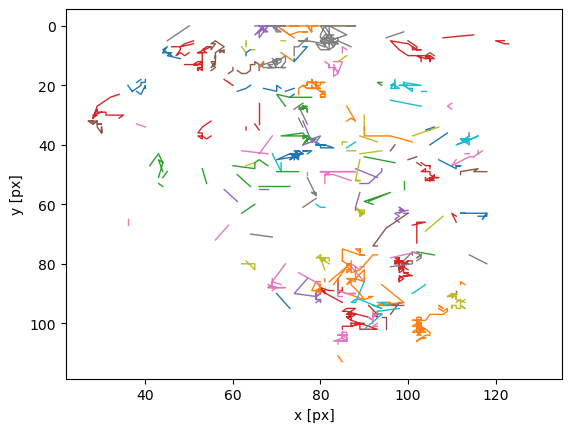

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [5]:
import trackpy as tp

farthest_distance = 8 # farthest distance a particle can travel, larger value slows computation time
track_linked = tp.link(particles_positions, farthest_distance, memory=5) # value of memory corresponds to the number of frames that is being memorized, track_linked is a pandas dataframe
nb_particles = track_linked['particle'].unique().max() + 1
print('There are', nb_particles, 'particles')

plt.figure()
tp.plot_traj(track_linked)

<div class="alert alert-success">

#### Exercise       

Try to understand the code line which generates the number of particles. <br>
What do you think will happen to this number of particles if you change the allowed farthest distance a particle can travel? <br>

(Here we have farthest_distance = 8 initially)
   
</div>

## Additional constraints

But maybe we eventually want to remove particles that are only appearing in few frames?

Let say we won't consider the trajectories of particles that are appearing in less than 10 frames.

In [6]:
import pandas as pd

l = track_linked['particle'].unique() 
allowed_track_length = 10
particles_id = [k for k in l if len(track_linked.loc[track_linked['particle']==k])>=allowed_track_length]

selected_tracks = pd.DataFrame([])

for t in range(len(particles_id)):
    coordinates = track_linked.loc[track_linked['particle']==particles_id[t]]
    selected_tracks = pd.concat([selected_tracks, coordinates])

selected_tracks

,x,y,w,frame,particle
4,108.0,95.0,1.0,0,1
9,107.0,94.0,1.0,1,1
9,108.0,95.0,1.0,2,1
7,108.0,95.0,1.0,3,1
11,108.0,95.0,1.0,4,1
...,...,...,...,...,...
5,87.0,93.0,1.0,100,209
3,87.0,93.0,1.0,101,209
1,88.0,93.0,1.0,102,209
2,88.0,93.0,1.0,103,209


#### Display the selected tracks over the images of the particles to see how well we did 

In [7]:
def displayTrack(t):
    myimg = np.squeeze(particles_data[t])

    plt.imshow(myimg)
    return tp.plot_traj(selected_tracks)

interact(displayTrack, t=(0, sz[0]-1, 1)) # min, max, step

interactive(children=(IntSlider(value=52, description='t', max=104), Output()), _dom_classes=('widget-interact…

<function __main__.displayTrack(t)>

<div class="alert alert-success">

#### Exercise       

Change the allowed_track_length and observe the number of trajectories displayed in the overlay display.
   
</div>

### Display tracks in napari

In [ ]:
points = tracks.loc[:, ["frame", "y", "x"]].to_numpy()
viewer.add_points(points, size=0.5, symbol="disc", face_color="white")

In [ ]:
tracks_to_napari = tracks.loc[:, ["particle", "frame", "y", "x"]].to_numpy()
viewer.add_tracks(tracks_to_napari, name="tracks", tail_length=5)

## Exporting tabular results

To save results in a csv file use the export function from pandas. <br>
The excelsheet will be save in your current directory. To check where is that directory, run the command pwd in a new cell and you will see the csv file be saved in that directory.


In [8]:
pwd

'c:\\Users\\Dina Ratsimandresy\\Documents\\GitHub\\introduction-to-python-bioimage-analysis\\nbs'

In [ ]:
selected_tracks.to_csv('tracking_results.csv')

# Some more helpful tips

- scientific images are data, they can be compromised by inappropriate manipulations
- take good images:
    - don't oversaturate your data
    - use the full dynamic range when taking your images
- do not segment on the data you are measuring, use a housekeeping channel
- images that are compared to each other need to be processed and acquired in the same manner